In [4]:
import matplotlib.pyplot as plt
import numpy as np
import keyboard as kb
import networkx as nx
from IPython.display import clear_output

In [2]:
class pawn:
    def __init__(self, x=0, y=0):
        self.x, self.y=x, y
        self.history=[]
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+"]"
    def move(self, direction):
        origin=[self.x, self.y]
        if direction=="left":
            if self.x > 0:
                self.x-=1
        elif direction=="right":
            if self.x < 8:
                self.x+=1
        elif direction=="up":
            if self.y > 0:
                self.y-=1
        elif direction=="down":
            if self.y < 8:
                self.y+=1
        elif direction=="doubleleft":
            if self.x > 1:
                self.x-=2
        elif direction=="doubleright":
            if self.x < 7:
                self.x+=2
        elif direction=="doubleup":
            if self.y > 1:
                self.y-=2
        elif direction=="doubledown":
            if self.y < 7:
                self.y+=2
        destination=[self.x, self.y]
        movement=[origin, destination]
        if movement not in self.history:
            self.history.append(movement)
    def future_move(self, direction):
        x, y=self.x, self.y
        fx, fy=x, y
        if direction=="left": fx-=1
        elif direction=="right": fx+=1
        elif direction=="up": fy-=1
        elif direction=="down": fy+=1
        elif direction=="doubleleft": fx-=2
        elif direction=="doubleright": fx+=2
        elif direction=="doubleup": fy-=2
        elif direction=="doubledown": fy+2
        return [[x, y], [fx, fy]]

    def coord(self):
        return [self.x, self.y]
    
    def near_coord(self):
        x, y=self.x, self.y
        return [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]

In [3]:
class wall:
    def __init__(self, x=0, y=0, direction="left"):
        self.x, self.y, self.direction=x, y, direction
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+", " + self.direction + "]"

In [4]:
class pawnController:
    def __init__(self):
        self.pawnList={}
    def add_pawn(self, name, pawn):
        if name not in self.pawnList:
            if 0 <= pawn.x <= 8 and 0 <= pawn.y <= 8: 
                self.pawnList[name]=pawn

    def matrix(self):
        matrix=[[0 for _ in range(9)] for _ in range(9)]
        for i in self.pawnList:
            pawn=self.pawnList[i]
            matrix[pawn.y][pawn.x]=1
        return matrix

    def move_pawn(self, name, direction):
        self.pawnList[name].move(direction)

    def detect_near(self, name):
        near_pos=self.pawnList[name].near_coord()
        for i in self.pawnList:
            pawn=self.pawnList[i]
            coord=pawn.coord()
            if coord==near_pos[0]:      return "left"
            elif coord==near_pos[1]:    return "up"
            elif coord==near_pos[2]:    return "right"
            elif coord==near_pos[3]:    return "down"
        return 0
    
    def can_move_to(self, name, ill_moves):
        pawn=self.pawnList[name]
        pos_moves=["down", "left", "right", "up"]
        if self.detect_near(name):
            near=self.detect_near(name)
            pos_moves[pos_moves.index(near)]="double"+pos_moves[pos_moves.index(near)]
        to_remove=[]
        for i in pos_moves:
            fut_move=pawn.future_move(i)
            if fut_move in ill_moves:
                to_remove.append(i)
        for i in to_remove:
            pos_moves.remove(i)
        return pos_moves


In [5]:
class wallController:
    def __init__(self):
        self.wallList={}
    def add_wall(self, name, wall):
        if name not in self.wallList:
            if wall.direction == "left" and 2 <= wall.x <= 9 and 1 <= wall.y <= 8:
                self.wallList[name]=wall
            elif wall.direction == "up" and 1 <= wall.x <= 8 and 2 <= wall.y <= 9:
                self.wallList[name]=wall
    def matrix(self):
        matrix=[[0 for _ in range(10)] for _ in range(10)]
        for i in self.wallList:
            wall=self.wallList[i]
            if wall.direction == "left":
                matrix[wall.y][wall.x-1]+=2
                matrix[wall.y][wall.x]+=2
            elif wall.direction == "up":
                matrix[wall.y][wall.x]+=3
                matrix[wall.y-1][wall.x]+=3
        return matrix

    def ill_moves(self, i_type):
        #i_type=full, wall
        illegal_moves=[]
        if i_type=="full":
            for i in range(9):
                illegal_moves.append([[0, i], [-1, i]])
                illegal_moves.append([[1, i], [-1, i]])
                illegal_moves.append([[8, i], [9, i]])
                illegal_moves.append([[7, i], [9, i]])
                illegal_moves.append([[i, 0], [i, -1]])
                illegal_moves.append([[i, 1], [i, -1]])
                illegal_moves.append([[i, 8], [i, 9]])
                illegal_moves.append([[i, 7], [i, 9]])
        for i in self.wallList:
            wall=self.wallList[i]
            x=wall.x
            y=wall.y
            if wall.direction=="left":
                illegal_moves.extend([[[x-1, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-1, y]],
                                        [[x-2, y], [x-2, y-1]],
                                        [[x-2, y-1], [x-2, y]],
                                        [[x-2, y-2], [x-2, y]],
                                        [[x-1, y-2], [x-1, y]],
                                        [[x-2, y+1], [x-2, y-1]],
                                        [[x-1, y+1], [x-1, y-1]],
                                        [[x-2, y-1], [x-1, y]],
                                        [[x-1, y], [x-2, y-1]],
                                        [[x-2, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-2, y]]])
            elif wall.direction=="up":
                illegal_moves.extend([[[x, y-2], [x-1, y-2]],
                                        [[x-1, y-2], [x, y-2]],
                                        [[x, y-1], [x-1, y-1]],
                                        [[x-1, y-1], [x, y-1]],
                                        [[x-2, y-2], [x, y-2]],
                                        [[x-2, y-1], [x, y-1]],
                                        [[x+1, y-2], [x-1, y-2]],
                                        [[x+1, y-1], [x-1, y-1]],
                                        [[x-1, y-2], [x, y-1]],
                                        [[x, y-1], [x-1, y-2]],
                                        [[x-1, y-1], [x, y-2]],
                                        [[x, y-2], [x-1, y-1]]])
        return illegal_moves

In [6]:
class board:
    def __init__(self):
        self.pawnController=pawnController()
        self.wallController=wallController()
    def get_pawn(self, name):
        return self.pawnController.pawnList[name]
    def add_pawn(self, name, pawn):
        self.pawnController.add_pawn(name, pawn)
    def move_pawn(self, name, direction):
        pawn=self.pawnController.pawnList[name]
        ill_moves=self.wallController.ill_moves("full")
        if self.pawnController.detect_near(name)==direction:
            direction="double"+direction
        if pawn.future_move(direction) in ill_moves:
            return 0
        else:
            if pawn.future_move(direction) not in pawn.history:
                repeating_move=False
            else: repeating_move=True
            self.pawnController.move_pawn(name, direction)
        if not repeating_move:
            return 1
        else:
            return 2
    def add_wall(self, name, wall):
        self.wallController.add_wall(name, wall)
    def get_wall(self):
        return self.wallController.wallList
    def ill_moves(self, i_type):
        return self.wallController.ill_moves(i_type)

In [7]:
def drawBoard(board_pawn, board_wall):
    n = len(board_pawn)
    tablero = np.zeros((n ,n, 3)) # Matriz de ceros. Doble paréntesis porque es inmutable (dupla)
    tablero += 0.8 # Degradado de color
    tablero[ ::2,  ::2] =1
    tablero[1::2, 1::2] =1 #Crea rejilla con 0.8 y 1 intercaladamente
    fig, ax = plt.subplots() #Subplots: funcion similar a buffer pero para gráficos estdísticos
    ax.imshow(tablero, interpolation='nearest')
    
    #g[posicion][valor]
    #g[fila][columna]=valor
    for y in range(len(board_pawn)):
        for x in range(len(board_pawn[y])):
            if board_pawn[y][x]==0:
                continue
            ax.text(x, y, '\u2655', size=30, ha='center', va='center')
    for y in range(len(board_wall)):
        for x in range(len(board_wall[y])):
            wall_type=board_wall[y][x]
            if wall_type==0:
                continue
            if wall_type==2 or wall_type==5:
                ax.text(x-1, y-.5, '\u2015', size=25, ha='center', va='center') #43 size
            if wall_type==3 or wall_type==5:
                ax.text(x-.5, y-1, '\u2015', size=25, rotation=90, ha='center', va='center')
    ax.set(xticks=[], yticks=[]) #no mostrar líneas de separación cartesianas
    ax.axis('image')
    plt.show()

['down', 'doubleright', 'up']


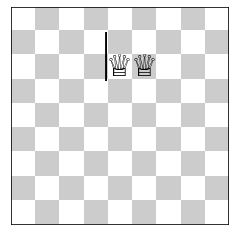

[[[4, 1], [3, 1]], [[3, 1], [4, 1]], [[4, 2], [3, 2]], [[3, 2], [4, 2]], [[2, 1], [4, 1]], [[2, 2], [4, 2]], [[5, 1], [3, 1]], [[5, 2], [3, 2]], [[3, 1], [4, 2]], [[4, 2], [3, 1]], [[3, 2], [4, 1]], [[4, 1], [3, 2]]]


In [8]:
b=board()
b.add_pawn("p1", pawn(5,2))
b.add_pawn("p2", pawn(4,2))
#print(b.pawnController.detect_near("p1"))
#b.add_wall("w1", wall(5, 2, "left"))
b.add_wall("w2", wall(4, 3, "up"))
b.move_pawn("p1", "left")
print(b.pawnController.can_move_to("p2", b.ill_moves("full")))
drawBoard(b.pawnController.matrix(), b.wallController.matrix())
print(b.ill_moves("wall"))
#print(b.wallController.wallList["w2"].x)

#clase game
#board, player
#player puede acceder a wallList
#board.getWall

In [9]:
"""class game:
    def __init__(self):
        #player
        self.board=board()
    def add_player(self, name, board):
        listadejugadores.append(player("ai", board))"""

'class game:\n    def __init__(self):\n        #player\n        self.board=board()\n    def add_player(self, name, board):\n        listadejugadores.append(player("ai", board))'

In [10]:
"""class player:
    def __init__(self, name, board):
        self.pawnName=name
        self.wallList=board.getWall()"""

'class player:\n    def __init__(self, name, board):\n        self.pawnName=name\n        self.wallList=board.getWall()'

In [11]:
b1=board()
b1.add_pawn("p1", pawn(4,0))
b1.add_wall("w3", wall(5, 1, "left"))
b1.add_wall("w4", wall(4, 2, "up"))
b1.add_wall("w5", wall(5, 2, "up"))
pos_moves=b1.pawnController.can_move_to("p1", b1.ill_moves("full"))
print(len(pos_moves))
print(b1.pawnController.can_move_to("p1", b1.ill_moves("full")))

while b1.pawnController.pawnList["p1"].y!=8:
    pos_moves=b1.pawnController.can_move_to("p1", b1.ill_moves("full"))
    if len(pos_moves)==0:
        break
    b1.move_pawn("p1", pos_moves[0])
if b1.pawnController.pawnList["p1"].y==8:
    print("yay")
else:
    print(":(")


0
[]
:(


['left']
False


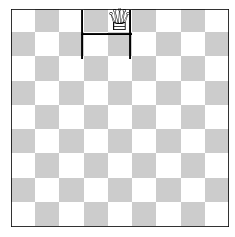

1


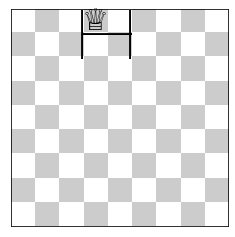

1


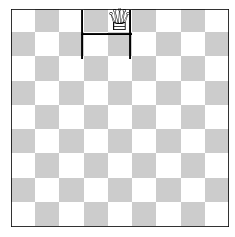

2


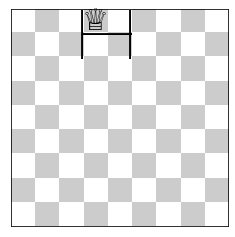

2


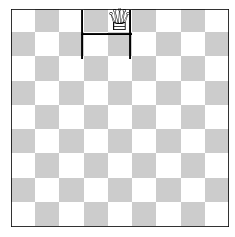

0


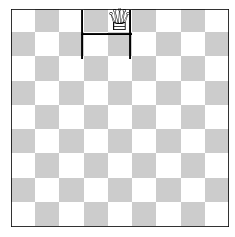

0


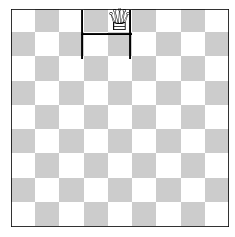

[[[4, 0], [3, 0]], [[3, 0], [4, 0]]]


In [12]:
b1=board()
b1.add_pawn("p2", pawn(4,0))

b1.add_wall("w3", wall(5, 1, "left"))
b1.add_wall("w4", wall(3, 2, "up"))
b1.add_wall("w5", wall(5, 2, "up"))
print(b1.pawnController.can_move_to("p2", b1.ill_moves("full")))
print([[4, 0], [3, 0]] in b1.ill_moves("full"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "left"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "right"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "left"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "right"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "down"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.move_pawn("p2", "up"))
drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())
print(b1.get_pawn("p2").history)

In [13]:
def solveBoard(board, target_row, name, direction):
    pawnCont=board.pawnController
    wallCont=board.wallController

    drawBoard(board.pawnController.matrix(),     board.wallController.matrix())

    if board.get_pawn(name).future_move(direction) in  board.ill_moves("full") or board.get_pawn(name).future_move(direction) in board.get_pawn(name).history:
        return False

    board.move_pawn(name, direction)

    if board.pawnController.pawnList[name].y == target_row:
        return True
    
    if solveBoard(board, target_row, name, "down"): 
        return True
    if solveBoard(board, target_row, name, "left"): 
        return True
    if solveBoard(board, target_row, name, "right"): 
        return True
    if solveBoard(board, target_row, name, "up"): 
        return True

    return False
    

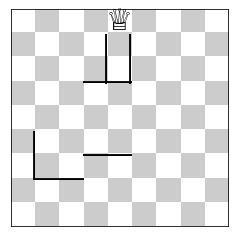

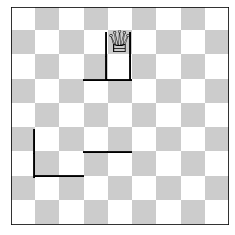

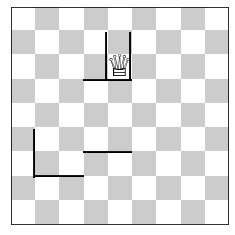

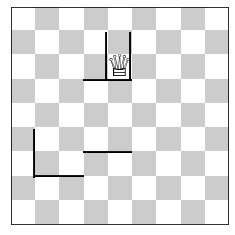

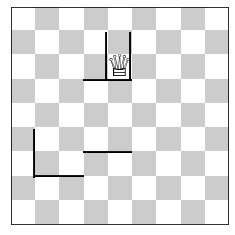

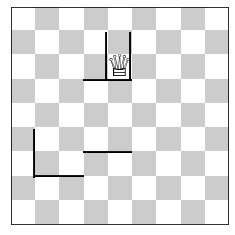

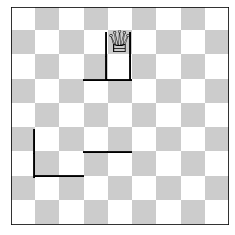

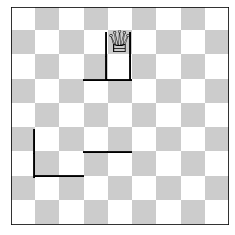

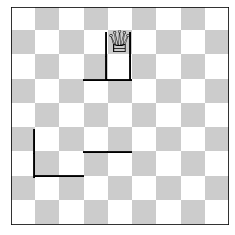

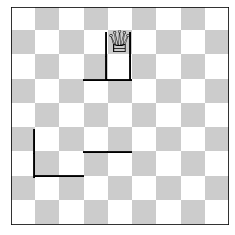

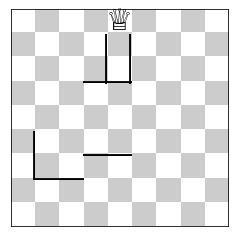

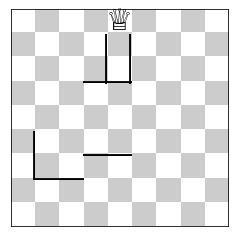

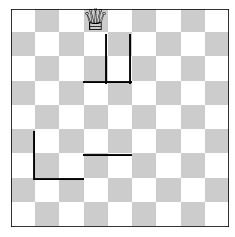

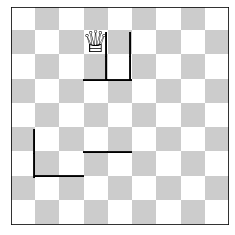

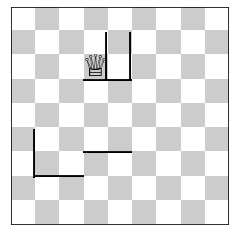

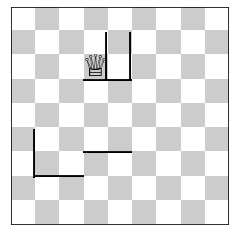

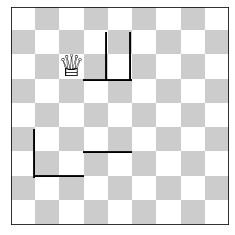

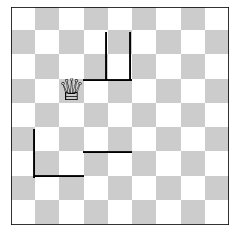

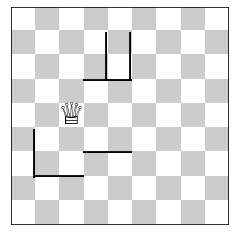

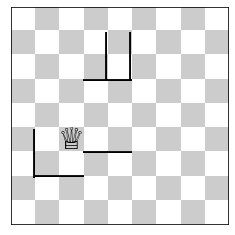

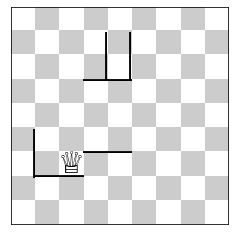

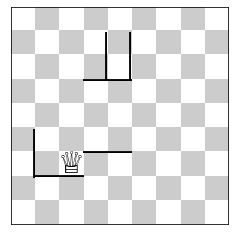

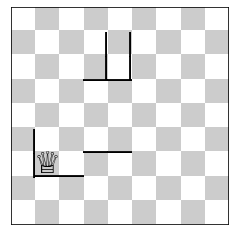

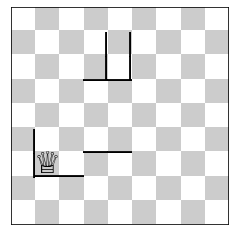

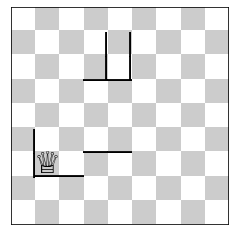

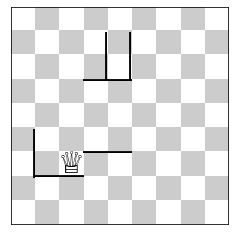

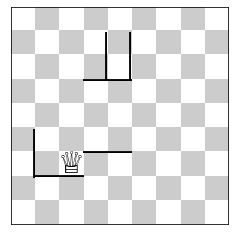

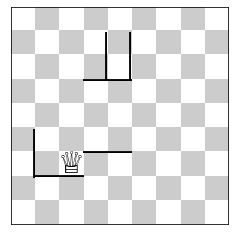

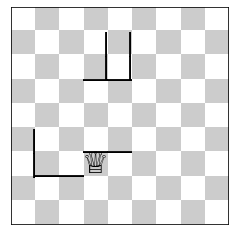

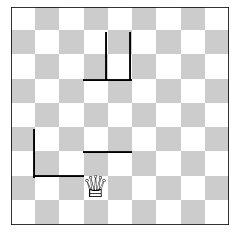

True

In [14]:
b2=board()
b2.add_pawn("Empe", pawn(4,0))

b2.add_wall("w3", wall(5, 6, "left"))
b2.add_wall("w5", wall(4, 3, "up"))
b2.add_wall("w6", wall(3, 7, "left"))
b2.add_wall("w7", wall(1, 7, "up"))
b2.add_wall("w8", wall(5, 3, "left"))
#b2.add_wall("t3", wall(5, 1, "left"))
#b2.add_wall("t4", wall(3, 2, "up"))
#b2.add_wall("t5", wall(5, 2, "up"))
b2.add_wall("F", wall(5, 3, "up"))
solveBoard(b2, 8, "Empe", "down")

In [15]:
def backtrack(board, target_row, pawn_name, direction):   
    wallCont=board.wallController
    if board.get_pawn(pawn_name).future_move(direction) in wallCont.ill_moves("full") or board.get_pawn(pawn_name).future_move(direction) in board.get_pawn(pawn_name).history:
        return False
    
    board.move_pawn(pawn_name, direction)
    drawBoard(b1.pawnController.matrix(), b1.wallController.matrix())

    if (board.get_pawn(pawn_name).y == target_row):
        return True

    if backtrack(board, target_row, pawn_name, "down"): return True
    if backtrack(board, target_row, pawn_name, "left"): return True
    if backtrack(board, target_row, pawn_name, "right"): return True
    if backtrack(board, target_row, pawn_name, "up"): return True

    return False

In [ ]:
b1=board()
b1.add_pawn("p2", pawn(4,0))

b1.add_wall("w5", wall(5, 2, "up"))
b1.add_wall("w6", wall(5, 5, "left"))
b1.add_wall("w7", wall(2, 5, "left"))
b1.add_wall("w8", wall(2, 7, "up"))
b1.add_wall("w9", wall(2, 8, "left"))
b1.add_wall("w10", wall(4, 8, "left"))
b1.add_wall("w11", wall(5, 8, "up"))
print(backtrack(b1, 8, "p2", "down"))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


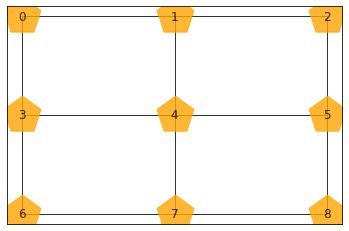

In [54]:
drawAL(G)

In [113]:
def buildBoard():
    nodes=[]
    Vx={}
    u=0
    for i in range(1, 10):
        for j in range(1, 10):
            nodes.append(chr(96+j)+str(i))
            Vx[nodes[-1]]=u
            u+=1
    conn=[]
    for i in nodes:
        pos_con=[]
        pos_con.append(chr(ord(i[0]))+str(int(i[1])-1))
        pos_con.append(chr(ord(i[0])+1)+str(int(i[1])))
        pos_con.append(chr(ord(i[0]))+str(int(i[1])+1))
        pos_con.append(chr(ord(i[0])-1)+str(int(i[1])))
        for_delete=[]
        for j in pos_con:
            if 96<ord(j[0])<106 and 0<int(j[1])<10 and len(j)==2:
                pass
            else: for_delete.append(j)
        for j in for_delete:
            pos_con.remove(j)
        to_add=[]
        for j in pos_con:
            to_add.append(Vx[j])
        conn.append(to_add)
    return nodes, conn, Vx

In [148]:
def drawAL2(V, G, Vx):
    gx=nx.Graph()
    nv=len(G) #num de vertices
    gx.add_nodes_from(V)
    for u in range(nv):
        for v in G[u]:
            gx.add_edge(V[u], V[v])
    pos=[]
    for y in range(8, -1, -1):
        for x in range(9):
            pos.append((x, y))
    nx.draw_networkx(gx,
            with_labels=True, 
            node_color='orange', 
            alpha=0.8, 
            node_size=1500, 
            node_shape='p')

In [153]:
#codigo para la representacion del tablero como grafo
G=[[1, 3],
    [0, 2, 4],
    [1, 5],
    [0, 4, 6],
    [1, 3, 5, 7],
    [2, 4, 8],
    [3, 7],
    [4, 6, 8],
    [5, 7]]
pos=[]
for y in range(2, -1, -1):
    for x in range(3):
        pos.append((x, y))
def drawAL(G):
    gx=nx.Graph()
    nv=len(G)
    gx.add_nodes_from([u for u in range(nv)])
    print(gx.nodes())
    for u in range(nv):
        for v in G[u]:
            gx.add_edge(u, v)
    nx.draw_networkx(gx,
            pos=multipartite_layout(gx),
            with_labels=True, 
            node_color='orange', 
            alpha=0.8, 
            node_size=1500, 
            node_shape='p')

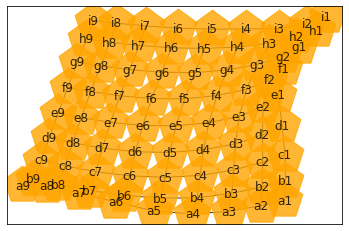

In [155]:
nodes, conn, Vx=buildBoard()
drawAL2(nodes, conn, Vx)